In [2]:
pip install pandas scikit-learn matplotlib seaborn xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv('predictive_maintenance_dataset.csv')

# Display the first few rows and basic info
print(df.head())
print(df.info())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

Loaded columns: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
Total lifecycles: 120, lifecycles with failure: 109
Features example: ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Air temperature [K]_roll_mean', 'Air temperature [K]_roll_std', 'Air temperature [K]_lag1', 'Process temperature [K]_roll_mean', 'Process temperature [K]_roll_std', 'Process temperature [K]_lag1', 'Rotational speed [rpm]_roll_mean', 'Rotational speed [rpm]_roll_std', 'Rotational speed [rpm]_lag1', 'Torque [Nm]_roll_mean', 'Torque [Nm]_roll_std', 'Torque [Nm]_lag1', 'Tool wear [min]_roll_mean', 'Tool wear [min]_roll_std', 'Tool wear [min]_lag1', 'omega_rad_s', 'Power_W', 'Temp_diff']
Training RandomForest...
Done.
RMSE: 19.348 cycles, MAE: 14.188 cycles, R2: 0.2537


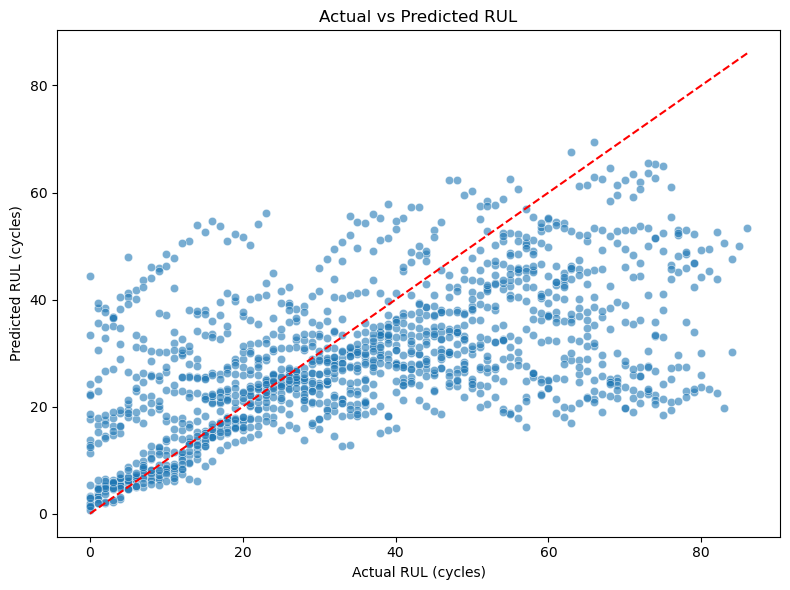

Top features:
                               feature  importance
4                     Tool wear [min]    0.152428
22                          Temp_diff    0.118958
8   Process temperature [K]_roll_mean    0.112266
17          Tool wear [min]_roll_mean    0.080863
19               Tool wear [min]_lag1    0.079302
5       Air temperature [K]_roll_mean    0.074419
12    Rotational speed [rpm]_roll_std    0.041389
15               Torque [Nm]_roll_std    0.038407
11   Rotational speed [rpm]_roll_mean    0.035900
18           Tool wear [min]_roll_std    0.033519
14              Torque [Nm]_roll_mean    0.032709
6        Air temperature [K]_roll_std    0.031662
1             Process temperature [K]    0.030448
0                 Air temperature [K]    0.027857
9    Process temperature [K]_roll_std    0.023010


In [49]:
# corrected_pipeline_fixed.py
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 0. Load ----------
df = pd.read_csv('predictive_maintenance_dataset.csv')  # change path if needed
print("Loaded columns:", df.columns.tolist())

# detect common column names
uid_col = 'UDI' if 'UDI' in df.columns else ('UID' if 'UID' in df.columns else None)
tool_col = 'Tool wear [min]' if 'Tool wear [min]' in df.columns else 'Tool wear' if 'Tool wear' in df.columns else None
failure_col = 'Machine failure' if 'Machine failure' in df.columns else ('machine_failure' if 'machine_failure' in df.columns else None)
type_col = 'type' if 'type' in df.columns else ('Type' if 'Type' in df.columns else None)

assert uid_col is not None, "No UID/UDI column found — update uid_col."
assert tool_col is not None, "No tool wear column found — update tool_col."
assert failure_col is not None, "No Machine failure column found — update failure_col."

# ---------- 1. Detect lifecycle resets ----------
# A lifecycle resets whenever tool wear decreases by more than tol (tunable).
tol = 0.5
tool = df[tool_col].astype(float)
reset_mask = (tool < tool.shift(1) - tol)  # True where tool wear dropped significantly
df['lifecycle_id'] = reset_mask.cumsum().astype(int)

# ---------- 2. Compute RUL in cycles ----------
n = len(df)
RUL_cycles = np.full(n, np.nan)

# We compute RUL per lifecycle: for rows up to the FIRST failure in that lifecycle,
# RUL = index_of_first_failure - current_row_index (in row count)
for gid, grp in df.groupby('lifecycle_id'):
    idx = grp.index.values
    fails = grp[failure_col].astype(int).values
    failure_positions = idx[fails == 1]
    if len(failure_positions) == 0:
        # no failure observed in this lifecycle -> censored
        continue
    # choose first failure in that lifecycle
    f = failure_positions[0]
    mask = idx <= f
    RUL_cycles[idx[mask]] = f - idx[mask]

df['RUL_cycles'] = RUL_cycles

# ---------- 3. Keep only complete run-to-failure lifecycles ----------
failed_lifecycles = df[df[failure_col] == 1]['lifecycle_id'].unique()
df_rul = df[df['lifecycle_id'].isin(failed_lifecycles)].copy()
print(f"Total lifecycles: {df['lifecycle_id'].nunique()}, lifecycles with failure: {len(failed_lifecycles)}")

# ---------- 4. Feature engineering ----------
# Sort so rolling is chronological within lifecycle
df_rul = df_rul.sort_values([ 'lifecycle_id', uid_col ]).reset_index(drop=True)

window_size = 10
features_to_roll = ['Air temperature [K]', 'Process temperature [K]',
                    'Rotational speed [rpm]', 'Torque [Nm]', tool_col]

# verify these exist
missing = [f for f in features_to_roll if f not in df_rul.columns]
if missing:
    raise ValueError(f"Missing columns required for rolling features: {missing}")

for feature in features_to_roll:
    df_rul[f'{feature}_roll_mean'] = df_rul.groupby('lifecycle_id')[feature].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)
    df_rul[f'{feature}_roll_std'] = df_rul.groupby('lifecycle_id')[feature].rolling(window=window_size, min_periods=1).std().reset_index(level=0, drop=True)
    df_rul[f'{feature}_lag1'] = df_rul.groupby('lifecycle_id')[feature].shift(1)

# Interaction / physically-correct power
# convert rpm -> rad/s then power = torque * omega
df_rul['omega_rad_s'] = df_rul['Rotational speed [rpm]'] * (2 * np.pi / 60.0)
df_rul['Power_W'] = df_rul['omega_rad_s'] * df_rul['Torque [Nm]']
df_rul['Temp_diff'] = df_rul['Process temperature [K]'] - df_rul['Air temperature [K]']

# ---------- 5. Prepare modeling dataframe ----------
df_model = df_rul.dropna(subset=['RUL_cycles']).copy()  # drop censored rows here
df_model['RUL'] = df_model['RUL_cycles']  # target in cycles (rows)

# drop columns that leak or are identifiers
drop_cols = [uid_col, 'Product ID', 'lifecycle_id', failure_col, 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'RUL_cycles']
drop_cols = [c for c in drop_cols if c in df_model.columns]
features = [c for c in df_model.columns if c not in drop_cols and c != 'RUL']

print("Features example:", features[:30])

# ---------- 6. Chronological lifecycle split ----------
unique_lifecycles_sorted = sorted(df_model['lifecycle_id'].unique())
split_idx = int(len(unique_lifecycles_sorted) * 0.8)
train_ids = unique_lifecycles_sorted[:split_idx]
test_ids = unique_lifecycles_sorted[split_idx:]

train_df = df_model[df_model['lifecycle_id'].isin(train_ids)]
test_df = df_model[df_model['lifecycle_id'].isin(test_ids)]

X_train = train_df[features].copy()
y_train = train_df['RUL'].copy()
X_test = test_df[features].copy()
y_test = test_df['RUL'].copy()

# ---------- 7. Handle categorical 'type' if present ----------
cols_to_encode = []
if type_col and type_col in X_train.columns:
    cols_to_encode = [type_col]

if cols_to_encode:
    X_train = pd.get_dummies(X_train, columns=cols_to_encode, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=cols_to_encode, drop_first=True)

# align columns (fills missing columns with zeros)
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

# ---------- 8. Train model ----------
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("Training RandomForest...")
rf.fit(X_train, y_train)
print("Done.")

# ---------- 9. Evaluate ----------
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f} cycles, MAE: {mae:.3f} cycles, R2: {r2:.4f}")

# scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual RUL (cycles)')
plt.ylabel('Predicted RUL (cycles)')
plt.title('Actual vs Predicted RUL')
plt.tight_layout()
plt.show()

# feature importance
feat_imp = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
print("Top features:\n", feat_imp.head(15))


In [51]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
